In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.stats import norm
import matplotlib.pyplot as plt

def finite_difference_opt(S0, r, sigma, K, T, Z=5, Nz=200, Nt=1000, option_type='call'):
    dz = 2*Z/(Nz - 1)
    dt = T/Nt
    z_grid = np.linspace(-Z, Z, Nz)
    
    if option_type == 'call':
        u = np.maximum(z_grid, 0)
    else:
        u = np.maximum(-z_grid, 0)

    for n in range(Nt):
        t_n = n*dt
        t_n_plus_1 = (n+1)*dt
        gamma_n = (1-np.exp(-r*t_n))/(r*T)
        gamma_n_plus_1 = (1-np.exp(-r*t_n_plus_1))/(r*T)
        
        a_n = (sigma**2 /2)*(gamma_n-z_grid)**2
        a_n_plus_1 = (sigma**2 /2)*(gamma_n_plus_1-z_grid)**2
        
        # Tridiagonal matrix A
        main = np.ones(Nz)
        lower = np.zeros(Nz-1)
        upper = np.zeros(Nz-1)
        
        for j in range(1, Nz-1):
            main[j] = 1 + dt*a_n_plus_1[j]/dz**2
            lower[j-1] = -1/2*dt*a_n_plus_1[j]/dz**2
            upper[j] = -1/2*dt*a_n_plus_1[j]/dz**2
        
        # Boundary
        if option_type == 'call':
            main[0], main[-1] = 1, 1
            upper[0], lower[-1] = 0, 0
        else:
            main[0], main[-1] = 1, 1
            upper[0], lower[-1] = 0, 0
        
        A_matrix = sp.diags([main, lower, upper], [0, -1, 1], format='csr')
        
        # B vector
        B_vec = np.zeros(Nz)
        if option_type == 'call':
            B_vec[0], B_vec[-1] = 0, Z
        elif option_type == 'put':
            B_vec[0], B_vec[-1] = Z, 0
        
        for j in range(1, Nz-1):
            laplacian = (u[j+1] - 2*u[j] + u[j-1]) / dz**2
            B_vec[j] = u[j] + 0.5 * dt * a_n[j] * laplacian
        
        u = spla.spsolve(A_matrix, B_vec)
    
    gamma_T = (1-np.exp(-r*T))/(r*T)
    z0 = gamma_T + (np.exp(-r*T)/S0)*(-K)
    u_value = np.interp(z0, z_grid, u)
    return S0*u_value

In [2]:
def geometric_asian_price(S0, K, r, sigma, T, option_type='call'):
    T_half = T/2
    sigma_sqrt = sigma*np.sqrt(T/3)
    mu = (r-sigma**2/2)*T_half
    d1 = (np.log(S0/K)+(r+sigma**2/6)*T_half)/sigma_sqrt
    d2 = d1-sigma_sqrt
    if option_type == 'call':
        return S0*np.exp(mu)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S0*np.exp(mu)*norm.cdf(-d1)

def asian_option_mc(S0, K, r, sigma, T, N=100000, dt=1/252, option_type='call', control=True):
    n_steps = int(T/dt)
    t = np.linspace(0, T, n_steps+1)
    discount = np.exp(-r*T)
    
    # Get paths
    np.random.seed(69)
    dW = np.random.normal(0, np.sqrt(dt), (N, n_steps))
    S = S0*np.exp(np.cumsum((r-sigma**2/2)*dt + sigma*dW, axis=1))
    S = np.hstack([S0*np.ones((N,1)), S])
    
    # Calculate average
    arithmetic_avg = np.mean(S, axis=1)
    geometric_avg = np.exp(np.mean(np.log(S), axis=1))
    
    # Payoff
    if option_type == 'call':
        payoff_arith = np.maximum(arithmetic_avg - K, 0)
        payoff_geo = np.maximum(geometric_avg - K, 0)
    else:
        payoff_arith = np.maximum(K - arithmetic_avg, 0)
        payoff_geo = np.maximum(K - geometric_avg, 0)
    
    # Control variate
    if control:
        geo_price = geometric_asian_price(S0, K, r, sigma, T, option_type)
        cov = np.cov(payoff_arith, payoff_geo)
        beta = cov[0,1]/cov[1,1]
        payoff_adj = payoff_arith -beta*(payoff_geo-geo_price)
    else:
        payoff_adj = payoff_arith
    
    price = discount*np.mean(payoff_adj)
    std_err = discount*np.std(payoff_adj)/np.sqrt(N)
    return price, std_err

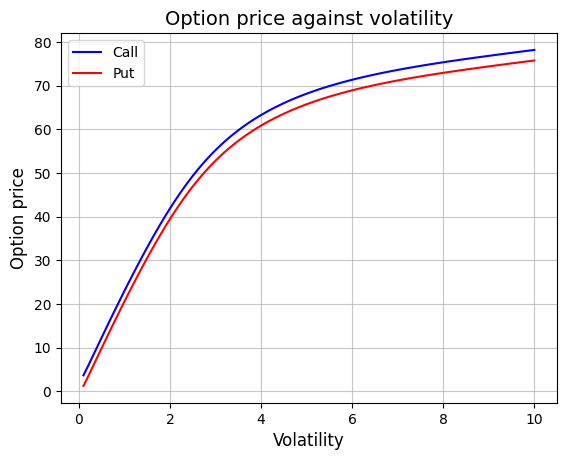

In [3]:
S0 = 100
K = 100
r = 0.05
T = 1
sigmas = np.linspace(0.1, 10, 100)

# Compute prices
call_prices = [finite_difference_opt(S0, r, sig, K, T, option_type='call') for sig in sigmas]
put_prices = [finite_difference_opt(S0, r, sig, K, T, option_type='put') for sig in sigmas]

# Plot
plt.plot(sigmas, call_prices, color='blue', label='Call')
plt.plot(sigmas, put_prices, color='red', label='Put')
plt.xlabel('Volatility', fontsize=12)
plt.ylabel('Option price', fontsize=12)
plt.title('Option price against volatility', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.7)
plt.show()

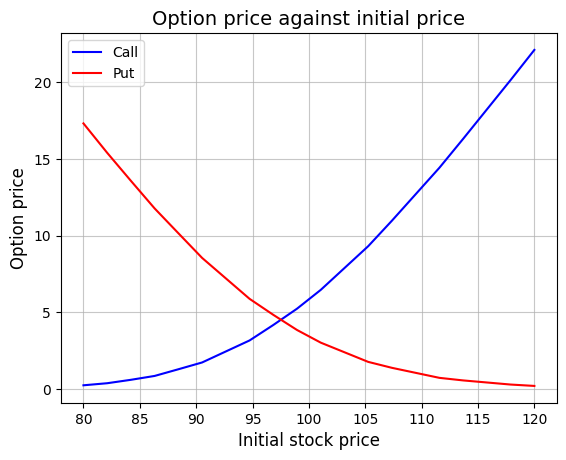

In [4]:
S0s = np.linspace(80, 120, 20)
sigma = 0.2

call_prices_S0 = [finite_difference_opt(S0, r, sigma, K, T, option_type='call') for S0 in S0s]
put_prices_S0 = [finite_difference_opt(S0, r, sigma, K, T, option_type='put') for S0 in S0s]

plt.plot(S0s, call_prices_S0, color='blue', label='Call')
plt.plot(S0s, put_prices_S0, color='red' , label='Put')
plt.xlabel('Initial stock price', fontsize=12)
plt.ylabel('Option price', fontsize=12)
plt.title('Option price against initial price', fontsize=14)
plt.grid(True, alpha=0.7)
plt.legend()
plt.show()

In [5]:
S0 = 100
sigma = 0.2
call = finite_difference_opt(S0, r, sigma, K, T, option_type='call')
put = finite_difference_opt(S0, r, sigma, K, T, option_type='put')
E_AT = (S0 / (r*T)) * (np.exp(r*T) - 1)
parity_RHS = np.exp(-r*T) * (E_AT - K)

print(f"Call - Put: {call - put:.4f}")
print(f"Parity RHS: {parity_RHS:.4f}")
print(f"Difference: {(call - put) - parity_RHS:.4f}")

Call - Put: 2.4182
Parity RHS: 2.4182
Difference: -0.0000


In [6]:
import time

# FD
start = time.time()
fd_price = finite_difference_opt(S0, r, sigma, K, T)
fd_time = time.time() - start

# MC (N=50,000)
start = time.time()
mc_price, mc_error = asian_option_mc(S0, K, r, sigma, T, N=50000)
mc_time = time.time() - start

print(f"FD Price: {fd_price:.4f}, Time: {fd_time:.2f}s")
print(f"MC Price: {mc_price:.4f} ± {mc_error:.4f}, Time: {mc_time:.2f}s")

FD Price: 5.7688, Time: 0.61s
MC Price: 8.0146 ± 0.0010, Time: 0.59s


In [10]:
import pandas as pd
def compare_methods():
    # Common parameters
    S0 = 100
    K = 100
    r = 0.05
    T = 1
    volatilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    
    results = []
    
    for sigma in volatilities:
        # Run FDM
        start_fdm = time.time()
        fdm_price = finite_difference_opt(S0, r, sigma, K, T, option_type='call')
        fdm_time = time.time() - start_fdm
        
        # Run MC
        start_mc = time.time()
        mc_price, mc_error = asian_option_mc(S0, K, r, sigma, T, option_type='call')
        mc_time = time.time() - start_mc
        
        results.append({
            'σ': sigma,
            'FDM Price': fdm_price,
            'MC Price': mc_price,
            'MC Std Error': mc_error,
            'FDM Time (s)': fdm_time,
            'MC Time (s)': mc_time
        })
    
    # Create DataFrame and format output
    df = pd.DataFrame(results)
    df.set_index('σ', inplace=True)
    return df.round(2)

# Execute comparison
results_df = compare_methods()
print(results_df)

     FDM Price  MC Price  MC Std Error  FDM Time (s)  MC Time (s)
σ                                                                
0.1       3.66      6.61          0.00          0.61         1.04
0.2       5.77      8.02          0.00          0.59         1.01
0.3       7.95      9.55          0.00          0.58         1.01
0.4      10.14     10.96          0.00          0.59         1.17
0.5      12.32     12.20          0.00          0.63         1.12
0.6      14.50     13.23          0.01          0.71         1.05
0.7      16.65     14.04          0.01          0.63         1.07
0.8      18.79     14.63          0.01          0.63         1.12
0.9      20.91     15.00          0.02          0.65         1.09
1.0      22.99     15.13          0.03          0.61         1.10
